In [5]:
!pip install sklearn
!pip install xlrd
!pip install matplotlib
!pip install eli5
!pip install pymorphy2
!pip install nltk
!pip install summa
!pip install python-rake

In [6]:
import pandas as pd
import re
import json
import numpy as np
from collections import Counter

In [7]:
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier


SEED = 54

In [8]:
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
import RAKE
rake = RAKE.Rake(stop_words)
from gensim.summarization import keywords as kw
from summa import keywords
from pymorphy2.tokenizers import simple_word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def fit_pred(X_train, X_test, y_train, y_test, clf=None):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print_report = classification_report(y_test, pred)
    report = classification_report(y_test, pred, output_dict=True)
    return pred, print_report, report

In [ ]:
def try_models(X_train, X_test, y_train, y_test):
    clf_logreg = LogisticRegression(random_state=SEED, solver='liblinear')
    clf_sgd = SGDClassifier(random_state=SEED)
    clf_forest = RandomForestClassifier(random_state=SEED)
    clf_bayes = MultinomialNB()
    clf_xgboost = XGBClassifier()

    clfs = {'logreg': {'model': clf_logreg, 'report': {}},
            'sgd': {'model': clf_sgd, 'report': {}},
            'forest': {'model': clf_forest, 'report': {}}, 
            'bayes':  {'model': clf_bayes,  'report': {}},
            'xgboost':  {'model': clf_xgboost,  'report': {}}
           }
    
    for name, clf in clfs.items():
        model = clf['model']
        _, print_report, report = fit_pred(X_train, X_test, y_train, y_test, clf=model)
        clfs[name]['report'] = report
        
    return clfs

In [13]:
def transform_data(train, test, col_name):
    y_train = train['index']
    y_test = test['index']

    X_train = train[col_name]
    X_test = test[col_name]
    
    vectorizer = TfidfVectorizer(analyzer=str.split)
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)

    
    return X_train, y_train, X_test, y_test

In [ ]:
with open('/content/meta.json', 'r') as f:
    meta = json.load(f)

In [10]:
train = pd.read_excel('/content/data_train.xlsx')
test = pd.read_excel('/content/data_test.xlsx')

In [11]:
train.shape, test.shape

((3984, 199), (1703, 199))

# подсчет метрик для всех моделей

In [ ]:
for m_id, m in meta.items():
    X_train, y_train, X_test, y_test = transform_data(train, test, int(m_id))
    reports = try_models(X_train, X_test, y_train, y_test)
    meta[str(m_id)]['reports'] = reports


weighted_fs = []
preps = []
models = []

for m_id, m in meta.items():
    for name, clf in m['reports'].items():
        score = clf['report']['weighted avg']['f1-score']
        weighted_fs.append(score)
        preps.append(m_id)
        models.append(name)


top_prep = []
top_model = []
top = {}
for m in list(set(models)):
  list_pr = []
  for i in np.argsort(weighted_fs)[::-1]:
      if weighted_fs[i] > 0.54 and models[i] == m:
        top_prep.append(preps[i])
        top_model.append(models[i])
        list_pr.append((preps[i], weighted_fs[i]))
      top[m] = list_pr[:20]

In [ ]:
list_prerp_type = []
for i, key in enumerate(top.keys()):
  list_prerp_type+= [x[0] for x in top[key]]

set_prerp_type = list(set(list_prerp_type))
df = pd.DataFrame(columns = set_prerp_type)

for pr_type in set_prerp_type:
  for i, key in enumerate(top.keys()):
    for score in top[key]:
      if score[0] == pr_type:
        df.loc[key, pr_type] = score[1]
df

,49,55,148,119,7,1,71,180,182,35,37,67,118,69,147,83,23,131,86,53,51,85,16,84,17,80,151,179,101,177,114,133,116,135,3,18,87,50,167,52,82,99,150,149,20,178,48,165,39,113,146,22,81,183,115,21,145,54,65,19,103,163
logreg,0.5922,0.59043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.596401,0.588617,0.59137,0.590477,NaN,0.594666,NaN,0.589195,NaN,0.592867,NaN,NaN,0.588592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589797,NaN,NaN,NaN,NaN,0.591964,NaN,NaN,0.588735,NaN,0.589879,NaN,NaN,NaN,NaN,0.589887,0.591794,NaN,NaN,0.589762,NaN,0.589997,NaN,0.594235,NaN,0.591238
xgboost,0.560022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555956,NaN,0.557643,0.560474,0.555953,NaN,0.562641,0.558572,0.557092,NaN,NaN,0.560383,NaN,0.55515,NaN,0.555156,NaN,NaN,0.554375,NaN,NaN,NaN,NaN,0.556566,NaN,NaN,NaN,NaN,NaN,NaN,0.554533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.559066,NaN,NaN,0.556292,0.559905,NaN,NaN,0.562143,0.557868,0.555768
bayes,NaN,NaN,0.575552,NaN,NaN,NaN,NaN,0.575567,0.57787,NaN,NaN,NaN,0.577475,NaN,NaN,NaN,NaN,NaN,0.579395,NaN,NaN,NaN,0.579816,0.581413,NaN,0.577884,NaN,NaN,NaN,NaN,NaN,NaN,0.57751,NaN,NaN,0.581483,NaN,0.581313,NaN,0.582611,0.580694,NaN,0.576704,NaN,0.58279,0.575652,0.577854,NaN,NaN,NaN,0.576194,0.581423,NaN,NaN,NaN,NaN,NaN,0.578778,NaN,NaN,NaN,NaN
forest,NaN,NaN,NaN,0.56213,NaN,NaN,NaN,0.564934,NaN,NaN,NaN,NaN,NaN,NaN,0.562802,0.565714,NaN,NaN,NaN,0.557717,0.56225,NaN,NaN,NaN,NaN,0.557958,0.557672,0.565737,NaN,0.558555,0.557031,NaN,NaN,NaN,NaN,NaN,0.56201,NaN,NaN,NaN,0.56454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.573702,NaN,NaN,0.561042,0.563978,0.560049,0.564527,0.562712,NaN,NaN,0.572432,NaN,NaN
sgd,NaN,NaN,NaN,NaN,0.588307,0.585017,0.586466,NaN,NaN,0.589488,0.587872,0.588522,NaN,NaN,NaN,0.585691,NaN,0.587952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587253,NaN,NaN,0.588116,NaN,NaN,0.585343,NaN,0.58472,0.585108,NaN,NaN,NaN,0.584922,NaN,NaN,0.585724,NaN,NaN,NaN,NaN,NaN,0.585889,0.586282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584719,0.586842,0.58636,NaN


лучшие типы препроцессинга

In [ ]:
df1 = pd.DataFrame()
for pr_type in set_prerp_type:
  if df[pr_type].isna().sum() <= 2:
    df1[pr_type] = df[pr_type]

df1

,83,131,51,80,87,81,21,19
logreg,0.596401,0.59137,0.594666,NaN,0.589797,0.591794,0.589762,0.594235
xgboost,0.557643,0.555953,0.558572,NaN,0.556566,0.559066,0.556292,0.562143
bayes,NaN,NaN,NaN,0.577884,NaN,NaN,NaN,NaN
forest,0.565714,NaN,0.56225,0.557958,0.56201,0.561042,0.564527,0.572432
sgd,0.585691,0.587952,NaN,0.587253,NaN,NaN,NaN,0.586842


In [ ]:
list_all_mean = [[], [], [], [], []]

for i, key in enumerate(top.keys()):
  mean_score = [x[1] for x in top[key]]
  list_all_mean[i] += mean_score

list_all_mean
df = pd.DataFrame()
df['logreg'] = list_all_mean[0]
df['bayes'] = list_all_mean[1]
df['xgboost'] = list_all_mean[2]
df['sgd'] = list_all_mean[3]
df['forest'] = list_all_mean[4]


df

,logreg,bayes,xgboost,sgd,forest
0,0.596401,0.582790,0.562641,0.589488,0.573702
1,0.594666,0.582611,0.562143,0.588522,0.572432
2,0.594235,0.581483,0.560474,0.588307,0.565737
3,0.592867,0.581423,0.560383,0.588116,0.565714
4,0.592200,0.581413,0.560022,0.587952,0.564934
5,0.591964,0.581313,0.559905,0.587872,0.564540
6,0.591794,0.580694,0.559066,0.587253,0.564527
7,0.591370,0.579816,0.558572,0.586842,0.563978
8,0.591238,0.579395,0.557868,0.586466,0.562802
9,0.590477,0.578778,0.557643,0.586360,0.562712


In [ ]:
print('bayes: ', df['bayes'].mean())
print('logreg: ', df['logreg'].mean())
print('forest: ', df['forest'].mean())
print('sgd: ', df['sgd'].mean())
print('XBoost: ', df['xgboost'].mean())

bayes:  0.5788988877374012
logreg:  0.5911052091435179
forest:  0.5628747013141313
sgd:  0.5865295655124866
XBoost:  0.5577779102884997


подсчет f1-score, precision, recall для лучших 8 типов препроцессинга

In [ ]:
print('weighted avg f1-score, precision, recall\n')

for m_id in ['19', '83', '131', '80', '87', '51', '21', '81']:
    X_train, y_train, X_test, y_test = transform_data(train, test, int(m_id))
    report = try_models(X_train, X_test, y_train, y_test)
    print('Preprocessing typenumber: ', m_id)
    for name, clf in report.items():
        print(f"{name.upper()}\t{clf['report']['weighted avg']['f1-score'], clf['report']['weighted avg']['precision'], clf['report']['weighted avg']['recall']}")        

weighted avg f1-score, precision, recall

Preprocessing typenumber:  19
LOGREG	(0.5942353695830646, 0.5932252499518064, 0.5989430416911333)
SGD	(0.5868417047222568, 0.5858375868557603, 0.5883734586024663)
FOREST	(0.5724324888301675, 0.5758999624262703, 0.5825014679976512)
BAYES	(0.5604807776526874, 0.5694423785787658, 0.5619495008807985)
XGBOOST	(0.5621427207865758, 0.568088233403218, 0.5719318849089842)
Preprocessing typenumber:  83
LOGREG	(0.5964005750014435, 0.5954257316710707, 0.6012918379330593)
SGD	(0.5856910263072955, 0.5848350245757385, 0.5871990604815033)
FOREST	(0.5657143273996671, 0.5691355252205779, 0.5748678802113917)
BAYES	(0.5594233054786835, 0.5689213279095533, 0.5607751027598356)
XGBOOST	(0.5576434927134176, 0.5624936266358024, 0.5666470933646506)
Preprocessing typenumber:  131
LOGREG	(0.5913696679157476, 0.5932533682397296, 0.5942454492072813)
SGD	(0.5879516299913536, 0.5876267869978782, 0.5883734586024663)
FOREST	(0.5424087168647218, 0.550708501758874, 0.558426306517

Confusion matrix, with normalization
[[416 114  55]
 [158 257 164]
 [ 73 119 347]]
Normalized confusion matrix
[[0.71111111 0.19487179 0.09401709]
 [0.27288428 0.44386874 0.28324698]
 [0.13543599 0.22077922 0.64378479]]


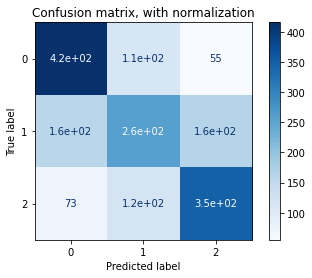

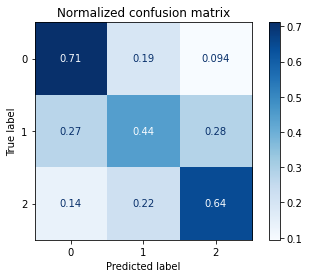

In [16]:
class_names = ['0', '1', '2']
clf_logreg = LogisticRegression(random_state=SEED, solver='liblinear')

prep_id = 19
X_train, y_train, X_test, y_test = transform_data(train, test, prep_id)
classifier = clf_logreg.fit(X_train, y_train)

titles_options = [("Confusion matrix, with normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# ключевые слова

In [ ]:
def normalize_text(text):
    lemmas = []
    for t in simple_word_tokenize(text):
        lemmas.append(
            m.parse(t)[0].normal_form)
    return ' '.join(lemmas)

def create_corpus_auto_keys(corpus):
    list_ra = []
    list_TextRank = []
    list_summa = []
    for text in corpus:
        
        ra = rake.run(text, maxWords=3, minFrequency=2)
        ra = [r[0] for r in ra]
        
        TextRank = kw(text, pos_filter=[], scores=True)
        TextRank = [t[0] for t in TextRank]
        
        summa = keywords.keywords(text, additional_stopwords=stop_words, scores=True)
        summa = [s[0] for s in summa]
        
        list_ra.append(ra)
        list_TextRank.append(TextRank)
        list_summa.append(summa)

    return list_ra, list_TextRank, list_summa

In [ ]:
data = pd.concat([train, test])

In [ ]:
class_0 = data[data['index'] == 0]['текст'].to_list()
class_1 = data[data['index'] == 1]['текст'].to_list()
class_2 = data[data['index'] == 2]['текст'].to_list()

In [ ]:
corpus_clean = []
for texts in [class_0, class_1, class_2]:
  corpus_clean.append(' '.join(texts))

In [ ]:
list_ra, list_TextRank, list_summa = create_corpus_auto_keys(corpus_clean)

пересечение между тремя вариантами поиска кючевых слов для каждого класса

In [ ]:
lex0 = set(list_ra[0]) & set(list_TextRank[0]) & set(list_summa[0])
lex1 = set(list_ra[1]) & set(list_TextRank[1]) & set(list_summa[1])
lex2 = set(list_ra[2]) & set(list_TextRank[2]) & set(list_summa[2])

In [ ]:
lex2

{'ахаха',
 'будут',
 'видимо',
 'видно',
 'власти',
 'время',
 'вроде',
 'говна',
 'говоришь',
 'года',
 'дело',
 'должен',
 'дурачок',
 'ебать',
 'жаль',
 'живут',
 'жизни',
 'знает',
 'идиот',
 'иностранцы',
 'какую',
 'кому',
 'короче',
 'которая',
 'которые',
 'кремлеботов',
 'кстати',
 'лексокон',
 'люди',
 'можешь',
 'никто',
 'нравится',
 'откуда',
 'отлично',
 'пиздец',
 'план',
 'пока',
 'понимаю',
 'понял',
 'понятно',
 'поэтому',
 'просто',
 'против',
 'россии',
 'скоро',
 'слыш',
 'страна',
 'такие',
 'таких',
 'темы',
 'хотя',
 'хуесос',
 'чучело',
 'шлюха',
 'ясно'}

пересечение трех множеств

In [ ]:
intersection = set(list_summa[0]) & set(list_summa[1]) & set(list_summa[2])
intersection

{'id',
 'будешь',
 'будут',
 'весь',
 'виде',
 'вообще',
 'время',
 'всё',
 'государство',
 'давай',
 'дальше',
 'делать',
 'друг',
 'который',
 'никто',
 'очень',
 'правильно',
 'просто',
 'сами',
 'своей',
 'такое',
 'хотя',
 'человек'}

разница 

In [ ]:
set(list_summa[2]) - (set(list_summa[0]) & set(list_summa[1]))

{'dавят',
 'абсолютно любой',
 'айфон',
 'активированного',
 'алексей',
 'алименты',
 'анальный',
 'андрей',
 'б путём обратной',
 'баба',
 'батя',
 'беги',
 'био',
 'бля',
 'блять',
 'большой',
 'бот',
 'бред',
 'ватник',
 'ваш',
 'везде боты',
 'верно',
 'весёлым',
 'взносы',
 'видно',
 'виталий',
 'виталик',
 'вкопипастил',
 'власть',
 'вместо',
 'вроде',
 'всей',
 'всем',
 'вся',
 'второй',
 'высирает такую',
 'выше',
 'гей',
 'гнилую',
 'говно',
 'говном',
 'говорить малолетний',
 'говорю',
 'головного',
 'гос',
 'давно',
 'даун',
 'дебил',
 'дегенерат',
 'дед',
 'демагогию',
 'деньги',
 'депутаты гордумы',
 'долбоебы',
 'должен',
 'дохлых',
 'дрочи',
 'думал',
 'дурачок',
 'дурной',
 'дырявый',
 'е',
 'еб',
 'ебаная',
 'ебаный',
 'ебать',
 'еблоид',
 'еврей',
 'емое',
 'её',
 'ждет конкурс',
 'жду',
 'жирно старайся',
 'жопа',
 'жопу',
 'заебал',
 'заканчивается',
 'залезло',
 'запуске',
 'зато',
 'звук',
 'здюлин',
 'знаешь старый',
 'знаю',
 'ибо твое',
 'иди',
 'извилиной',
 '

In [ ]:
set(list_summa[1]) - (set(list_summa[0]) & set(list_summa[2]))

{'adik',
 'club',
 'upd',
 'абсолютно',
 'авто',
 'ага',
 'агрессия',
 'адекватные',
 'активность глупая трата времени',
 'алексей',
 'анкапские',
 'башкой',
 'бесит тупая',
 'благодаря',
 'бля',
 'блять',
 'боксёрский',
 'бот',
 'бред',
 'буду',
 'бутылку леха',
 'ванюша',
 'вася',
 'ваша',
 'ваше',
 'ваши',
 'ваших',
 'ведомым',
 'ведущая',
 'велит',
 'веришь',
 'вести',
 'вещь',
 'вид',
 'вида',
 'видео',
 'видимо',
 'видят',
 'вк пропагандистской',
 'власти',
 'вместо',
 'вне',
 'внимание',
 'возит',
 'вопрос',
 'вопросы',
 'воровать',
 'вроде',
 'врывается',
 'всем',
 'выводу',
 'выводы насчёт',
 'выглядеть',
 'выписал',
 'выпустил',
 'выше',
 'генных',
 'германии',
 'гипотетически',
 'главное',
 'глаза',
 'глянь сколько стоит',
 'говна',
 'говно',
 'говоря',
 'головой',
 'гораздо',
 'гранты',
 'грубость',
 'дай',
 'далеко',
 'даунов',
 'даёт',
 'движение',
 'делают',
 'дело',
 'держи',
 'десятки',
 'дешевым пальмовым',
 'деятельностью',
 'джинс матня',
 'дитя',
 'довода',
 'доказ

In [ ]:
set(list_summa[1]) - (set(list_summa[0]) & set(list_summa[2]))

{'space',
 'автобус',
 'ага',
 'акции',
 'алиса',
 'амтронавтов',
 'анатолий',
 'бас совершенно подругому',
 'белых',
 'белье',
 'ближе',
 'блюд',
 'болит',
 'бумажки',
 'бывшего директора',
 'вариант',
 'видна слегка',
 'виду мелких',
 'вижу',
 'власти',
 'влияние данной',
 'внимательно читал',
 'воздух',
 'возможно',
 'вопрос',
 'вполне',
 'врачи',
 'времени',
 'всеми',
 'второй',
 'выглядящие',
 'высказывал',
 'высокой',
 'г',
 'глазу часто',
 'гляньте',
 'говорил',
 'говорит',
 'говорят',
 'год',
 'году',
 'годы мама',
 'голову',
 'горбу',
 'города',
 'городах',
 'городе',
 'градуса',
 'гриб',
 'группа',
 'грыжей крестцового',
 'давным',
 'дали',
 'двух морей',
 'делают',
 'дело',
 'днем',
 'днях',
 'довольно',
 'дом',
 'дорогие',
 'дороже',
 'доступе',
 'другое',
 'друзей',
 'думаю',
 'еды',
 'ездить',
 'естественно',
 'ефремов',
 'ещё',
 'жизнь идёт',
 'жил',
 'жить',
 'звероподобный',
 'знает',
 'знак',
 'знакомые',
 'значит',
 'золотых',
 'иван',
 'игры',
 'имеет',
 'именно',
 

In [ ]:
data_keys = pd.DataFrame(columns = ['rake0', 'rake1', 'rake2', 'TextRank0', 'TextRank1', 'TextRank2', 'summa0', 'summa1', 'summa2', 'lex0', 'lex1', 'lex2'])
data_keys['rake0'] = pd.Series(list_ra[0])
data_keys['rake1'] = pd.Series(list_ra[1])
data_keys['rake2'] = pd.Series(list_ra[2])
data_keys['TextRank0'] = pd.Series(list_TextRank[0])
data_keys['TextRank1'] = pd.Series(list_TextRank[1])
data_keys['TextRank2'] = pd.Series(list_TextRank[2])
data_keys['summa0'] = pd.Series(list_summa[0])
data_keys['summa1'] = pd.Series(list_summa[1])
data_keys['summa2'] = pd.Series(list_summa[2])
data_keys['lex0'] = pd.Series(list(lex0))
data_keys['lex1'] = pd.Series(list(lex1))
data_keys['lex2'] = pd.Series(list(lex2)) 

In [ ]:
df = pd.DataFrame({'rake0': list_ra[0]}) 
df1 = pd.DataFrame({'rake1': list_ra[1]})
df2 = pd.DataFrame({'rake2': list_ra[2]})
df3 = pd.DataFrame({'TextRank0': list_TextRank[0]})
df4 = pd.DataFrame({'TextRank1': list_TextRank[1]})
df5 = pd.DataFrame({'TextRank2': list_TextRank[2]})
df6 = pd.DataFrame({'summa0': list_summa[0]})
df7 = pd.DataFrame({'summa1': list_summa[1]})
df8 = pd.DataFrame({'summa2': list_summa[2]})
df9 = pd.DataFrame({'lex0': list(lex0)})
df10 = pd.DataFrame({'lex1': list(lex1)})
df11 = pd.DataFrame({'lex2': list(lex2)})
a = pd.concat([df,df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True, axis=1)